In [1]:
# Dataclass Preparation
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import dlib
from imutils import face_utils
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import numpy as np
import os
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from glob import glob
import segmentation_models_pytorch as smp
import torch.nn.functional as F
import cv2
import time 
import mediapipe
from torchvision import transforms
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2
import glob
from torchvision.models.feature_extraction import create_feature_extractor
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")




In [2]:
# Load the Model 
model_path = "/home/nipun/Documents/Uni_Malta/LuminEye/LuminEye-Experiments/U2net/U2NET_MULTICLASS_IMG_256_DIC_batch_8/Miche_model_2023_04_11_22:14:26_val_iou0.900.pt"


    

In [3]:
class  CenterRegressionModel(nn.Module):
    def __init__(self,segmentation_path):
        super().__init__()
        self.base_model = torch.load(segmentation_path)
        
        self.numbers = ["1","2","3","4","5","6"]

        for name,param in self.base_model.named_parameters():
            if name.split(".")[0][-1] in self.numbers and name.split(".")[0][:-1]=="stage":
                
                param.requires_grad_(False)
                
                
        self.regressor = nn.Sequential(
                        nn.Flatten(),
                        nn.Linear(196608,1024),
                        nn.ReLU(),
                        nn.Linear(1024,512),
                        nn.ReLU(),
                        nn.Linear(512,256),
                        nn.ReLU(),
                        nn.Linear(256,128),
                        nn.ReLU(),
                        nn.Linear(128,64),
                        nn.ReLU(),
                        nn.Linear(64,32),
                        nn.ReLU(),
                        nn.Linear(32,2),
                        nn.Sigmoid()
                    )
        
    def forward(self,x):
        
        d0,d1,d2,d3, d4, d5, d6 =  self.base_model(x)
        
        regressor_1 = self.regressor(d1)
        
        regressor_2 = self.regressor(d2)
        regressor_3 = self.regressor(d3)
        
        regressor_4 = self.regressor(d4)
        
        regressor_5 = self.regressor(d5)
        regressor_6 = self.regressor(d6)
        
        regressor_main = self.regressor(d0)
        
        
        return regressor_main,regressor_1,regressor_2,regressor_3,regressor_4,regressor_5,regressor_6
        
    
    
    
    
    

In [4]:
IMAGE_DIR = "/home/nipun/Documents/Uni_Malta/LuminEye/LuminEye-Iris-Center-Localization/G4_BIO_EYES"

In [5]:
df = pd.read_csv("/home/nipun/Documents/Uni_Malta/LuminEye/LuminEye-Iris-Center-Localization/GI4E_BIOID_MIXED.csv")

In [6]:
trn_ids,val_ids = train_test_split(df.Image_Name.unique(),test_size=0.2,random_state=99)
trn_df,val_df = df[df['Image_Name'].isin(trn_ids)], df[df['Image_Name'].isin(val_ids)]

In [7]:
class CenterDataset(torch.utils.data.Dataset):
    def __init__(self,df,image_dir=IMAGE_DIR,transforms=None):
        self.image_dir = image_dir
        self.df = df
        self.image_ids = df.Image_Name.unique()
        self.transforms = transforms
        
    def __getitem__(self,ix):
        
        img_id = self.image_ids[ix]
        img_path = os.path.join(self.image_dir,img_id)
        
        img = cv2.imread(img_path)[:,:,::-1]
        
        data = self.df[self.df["Image_Name"]==img_id]
        
        
        x1 = data["X1"].values[0]
        y1 = data["Y1"].values[0]
        
        center_loc = torch.Tensor([x1,y1])
        
        
        if self.transforms:
            transformed = self.transforms(image=img)
            
            image = transformed["image"]
            
    
        return image,center_loc
    def collate_fn(self,batch):
        return tuple(zip(*batch))
    
    def __len__(self):
        return len(self.image_ids)

In [8]:
RESIZE_AMT = 256
train_transforms =  A.Compose([
    A.Resize(width=RESIZE_AMT,height=RESIZE_AMT),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(p=1)
])

val_transforms =  A.Compose([
    A.Resize(width=RESIZE_AMT,height=RESIZE_AMT),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(p=1)
])

In [9]:
train_ds = CenterDataset(trn_df,transforms=train_transforms)
test_ds = CenterDataset(val_df,transforms=val_transforms)

In [10]:
img,center_loc = train_ds[3234]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


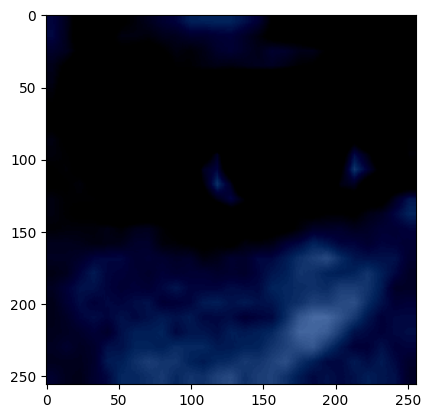

In [11]:
# Visualization
image = img.permute(1,2,0).detach().cpu().numpy()


h,w,_ = image.shape


center_loc = center_loc.detach().cpu().numpy()[0]

# cv2.circle(image,(int(center_loc[0]*RESIZE_AMT),int(center_loc[1]*RESIZE_AMT)),1,(255,0,0),-1)

plt.imshow(image)

In [12]:
# Training 
trainLoader = DataLoader(train_ds, batch_size=1,
	shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
testLoader = DataLoader(test_ds, batch_size=1,
	num_workers=os.cpu_count(), pin_memory=True)

In [13]:
MODEL = CenterRegressionModel(model_path)
MODEL.to(device)

CenterRegressionModel(
  (base_model): U2NET(
    (stage1): RSU7(
      (rebnconvin): REBNCONV(
        (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_s1): ReLU(inplace=True)
      )
      (rebnconv1): REBNCONV(
        (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_s1): ReLU(inplace=True)
      )
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (rebnconv2): REBNCONV(
        (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_s1): ReLU(inplace=True)
      )
      (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

In [14]:
opt = Adam(MODEL.parameters(),lr=0.0001)

epochs = 30

In [15]:
def multi_mse_loss_function(y0, y1, y2,y3, y4, y5, y6,y):
    
    mse_loss = nn.MSELoss()
    loss_1 = mse_loss(y0,y)
            
    loss_2 = mse_loss(y1,y)
            
    loss_3 = mse_loss(y2,y)
             
    loss_4 = mse_loss(y3,y)
      
    loss_5 = mse_loss(y4,y)
      
      
    loss_6 = mse_loss(y5,y)
      
      
    loss_7 = mse_loss(y6,y)
      
    loss = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7
    
    return loss_1,loss

In [16]:
for e in range(epochs):
    for idx,(images,coord) in enumerate(trainLoader):
        
        images = images.to(device)
        coord = coord.to(device)
        
        # print(images.shape)
        
        # print(coord.shape)
        
        
        regressor_main,regressor_1,regressor_2,regressor_3,regressor_4,regressor_5,regressor_6  = MODEL(images)
        
        
        loss_1,loss = multi_mse_loss_function(regressor_main,
                                            regressor_1,
                                            regressor_2,
                                            regressor_3,
                                            regressor_4,
                                            regressor_5,
                                            regressor_6,
                                            coord)
        
        
        print(f"Bounding Box Regression Loss--> {loss.item()}")
        
        
        
        loss.backward()
        opt.zero_grad()
        opt.step()    
        
    # break

/home/nipun/.local/lib/python3.10/site-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Bounding Box Regression Loss--> 0.11846017837524414


RuntimeError: CUDA out of memory. Tried to allocate 768.00 MiB (GPU 0; 5.81 GiB total capacity; 4.14 GiB already allocated; 703.38 MiB free; 4.18 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF